In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def read_tsv_data(dir, category):
    f = os.path.join(dir_path, '%s.list.tsv.gz' % category)
    df = pd.read_csv(f, sep='\t', encoding='latin1', index_col='id')
    
    df.drop(['episode'], axis=1, inplace=True)
    if category == 'language':
        df.drop(['suspended'], axis=1, inplace=True)
    
    print(len(df))
    return df

#### Read IMDB tsv files

In [3]:
dir_path = '..\\results\\intermediate\\complete\\json2tsv'

In [4]:
movies_pd = read_tsv_data(dir_path, category='movies')
movies_pd.head(3)

1055072


,kind,title,year,year_first,year_rest
id,,,,,
# (2012/I),movie,#,[2012],2012.0,NaN
# (2012/II),movie,#,[2012],2012.0,NaN
# (2014),movie,#,[2014],2014.0,NaN


In [5]:
country_pd = read_tsv_data(dir_path, category='countries')
country_pd.head(3)

1034831


,kind,title,countries,countries_first,countries_rest
id,,,,,
# (2012/I),movie,#,['USA'],USA,NaN
# (2012/II),movie,#,['Brazil'],Brazil,NaN
# (2014),movie,#,['USA'],USA,NaN


In [6]:
language_pd = read_tsv_data(dir_path, category='language')
language_pd.head(3)

919881


,kind,title,languages,languages_first,languages_rest
id,,,,,
# (2012/I),movie,#,[{'name': 'English'}],English,NaN
# (2012/II),movie,#,[{'name': 'Portuguese'}],Portuguese,NaN
# (2014),movie,#,"[{'name': 'English', 'note': '(English version...",English,NaN


In [10]:
runtime_pd = read_tsv_data(dir_path, category='running-times')
runtime_pd.head(3)

662420


,kind,title,running_times,running_times_first,running_times_rest
id,,,,,
# (2012/I),movie,#,[{'secs': 900}],900.0,NaN
# (2012/II),movie,#,"[{'secs': 480, 'country': 'Brazil'}]",480.0,NaN
#1 (2005),movie,#1,"[{'secs': 1800, 'country': 'USA'}]",1800.0,NaN


###### Merge all together

In [8]:
merged_pd = pd.concat([movies_pd, 
                       country_pd['countries_first'], 
                       language_pd['languages_first'], 
                       runtime_pd['running_times_first']], 
                      axis=1, join='inner')
merged_pd.drop(['year', 'year_rest'], axis=1, inplace=True)
print(len(merged_pd))
merged_pd.head(3)

616248


,kind,title,year_first,countries_first,languages_first,running_times_first
id,,,,,,
# (2012/I),movie,#,2012.0,USA,English,900.0
# (2012/II),movie,#,2012.0,Brazil,Portuguese,480.0
#1 (2005),movie,#1,2005.0,USA,English,1800.0


In [9]:
# delete unneeded df to save memory
del movies_pd, country_pd, language_pd, runtime_pd

###### Movie count by year

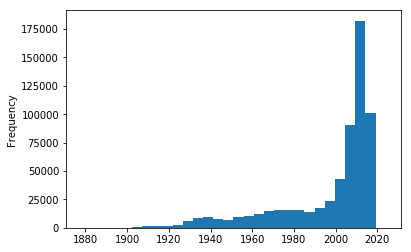

In [10]:
merged_pd['year_first'].plot.hist(bins=30)

###### Convert runtime in seconds to hours

In [11]:
merged_pd['running_times_first'] = merged_pd['running_times_first'] / 3600
merged_pd.head(3)

,kind,title,year_first,countries_first,languages_first,running_times_first
id,,,,,,
# (2012/I),movie,#,2012.0,USA,English,0.250000
# (2012/II),movie,#,2012.0,Brazil,Portuguese,0.133333
#1 (2005),movie,#1,2005.0,USA,English,0.500000


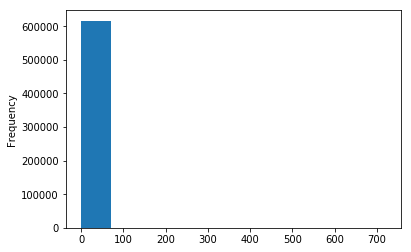

In [12]:
merged_pd['running_times_first'].plot.hist()

#### Filter too-long and too-short movies AND movies before 1991 and after 2017

In [13]:
OneHourOrLess_s = merged_pd['running_times_first'] <= 1.0
FiveHourOrMore_s = merged_pd['running_times_first'] >= 5.0

Total number of movies with runtime >5 hrs

In [14]:
len(merged_pd[FiveHourOrMore_s])

270

Total number of movies with runtime <1 hour

In [15]:
len(merged_pd[OneHourOrLess_s])

380983

In [16]:
len(merged_pd[merged_pd['running_times_first'] <= 0.75])

349011

In [17]:
filt_runtime_year_pd = merged_pd[(~OneHourOrLess_s 
                           & ~FiveHourOrMore_s 
                           & (merged_pd['year_first']>1990)
                           & (merged_pd['year_first']<=2017)
                          )].copy()
len(filt_runtime_year_pd)

134526

###### Filter countries with <=50 movies

In [18]:
movieCountByCountry = filt_runtime_year_pd['countries_first'].value_counts()
country51orMore = movieCountByCountry[movieCountByCountry>50]

In [19]:
filt_runtime_year_country_pd = filt_runtime_year_pd[filt_runtime_year_pd['countries_first']\
                                                    .isin(country51orMore.index)].copy()
filt_runtime_year_country_pd.head()

,kind,title,year_first,countries_first,languages_first,running_times_first
id,,,,,,
#1 Serial Killer (2013),movie,#1 Serial Killer,2013.0,USA,English,1.450000
#5 (2013),movie,#5,2013.0,USA,English,1.133333
#50Fathers (2015),movie,#50Fathers,2015.0,USA,English,2.200000
#66 (2015),movie,#66,2015.0,Indonesia,Indonesian,1.933333
"#73, Shaanthi Nivaasa (2007)",movie,"#73, Shaanthi Nivaasa",2007.0,India,Kannada,2.616667


In [20]:
# filt_runtime_year_pd.groupby(['countries_first', 'languages_first'])['countries_first'].count()\
#                 .to_csv('../results/country2language.tsv', sep='\t')
# filt_runtime_year_pd.groupby(['languages_first', 'countries_first'])['countries_first'].count()\
#                 .to_csv('../results/language2country.tsv', sep='\t')

In [21]:
axs = pd.pivot_table(filt_runtime_year_country_pd, index=['countries_first', 'languages_first'],
              values=['running_times_first'], aggfunc='mean')
#               values=['running_times_first', 'kind'], aggfunc=['mean', 'count'])
axs.head(5)

running_times_first
countries_first languages_first                     
Algeria         Arabic                      1.681667
                Berber                      1.716667
                English                     1.616667
                French                      1.540909
Argentina       Aboriginal                  1.166667

In [22]:
bxs = pd.pivot_table(filt_runtime_year_country_pd, index=['countries_first', 'languages_first'],
                     values=['kind'], aggfunc='count')
bxs.head(5)

kind
countries_first languages_first      
Algeria         Arabic             40
                Berber              2
                English             1
                French             22
Argentina       Aboriginal          1

In [23]:
cxs = pd.concat([axs, bxs], axis=1)
cxs.head()

running_times_first  kind
countries_first languages_first                           
Algeria         Arabic                      1.681667    40
                Berber                      1.716667     2
                English                     1.616667     1
                French                      1.540909    22
Argentina       Aboriginal                  1.166667     1

In [24]:
cxs.to_csv('../results/country_language_runtime_count.tsv', sep='\t')

###### Country vs runtime

In [25]:
pivot_country_runtime = filt_runtime_year_country_pd.groupby('countries_first').aggregate({'running_times_first':'mean', 
                                                                   'kind':'count'})
pivot_country_runtime.head(3)

,running_times_first,kind
countries_first,,
Algeria,1.634103,65
Argentina,1.460100,2439
Armenia,1.526537,103


In [26]:
len(pivot_country_runtime)

87

In [27]:
pivot_country_runtime.to_csv('../results/country_runtime_count.tsv', sep='\t')

#### Miscellaneous

#### Filter out languages with threshold count

In [ ]:
movieCountByLang = filt_count_pd['languages_first'].value_counts()
lang_count_10orMore = movieCountByLang[movieCountByLang>=10]
lang_count_25orMore = movieCountByLang[movieCountByLang>=25]
lang_count_50orMore = movieCountByLang[movieCountByLang>=50]

In [ ]:
filt_count_lang_pd = filt_count_pd[filt_count_pd['languages_first'].isin(lang_count_50orMore.index)]
len(filt_count_lang_pd)

#### Language vs Runtime

In [ ]:
lang_vs_runtime_pivot = pd.pivot_table(filt_count_lang_pd, index='languages_first', values='running_times_first', aggfunc='mean')
lang_vs_runtime_pivot.head()

In [ ]:
lang_vs_runtime_pivot[lang_vs_runtime_pivot['running_times_first']>2]

In [ ]:
lang_vs_runtime_pivot.to_csv('../results/lang_vs_runtime.tsv', sep='\t', 
                             index_label='language')

In [ ]:
lang_vs_runtime_pivot['running_times_first'].plot.hist()

In [ ]:
filt_count_lang_pd['languages_first'].value_counts()

In [ ]:
filt_count_lang_pd.groupby(['countries_first', 'languages_first'])['countries_first'].count()\
                .to_csv('../results/country2language.tsv', sep='\t')
filt_count_lang_pd.groupby(['languages_first', 'countries_first'])['countries_first'].count()\
                .to_csv('../results/language2country.tsv', sep='\t')

In [ ]:
filt_count_lang_pd['year_first'].plot.hist()